In [253]:
import plyvel
import orjson

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from itertools import islice, chain

import numpy as np

In [178]:
def iterate_reviews(db_path, n=None):
    db = plyvel.DB(db_path)
    if n is None:
        yield from db
    else:
        yield from islice(iter(db), n)
        
    db.close()
    
def extract_review_texts(value):
    try:
        reviews = [r['review_text'].get('full_html')
                  for r in orjson.loads(value).get('reviews', {}).get('other_user_review', [])
                  if 'review_text' in r]
        
        return [r for r in reviews if r]
    except Exception as e:
        print(f"Failed: {e}")
        return []
    
def iterate_review_texts(db_path, n=None, flatten=False):
    for key, review in iterate_reviews(db_path, n=n):
        place_id = key.split(b':')[-1].decode('utf8')
        if flatten:
            yield from extract_review_texts(review)
        else:
            yield place_id, extract_review_texts(review)
            
def get_review_texts_by_id(db, place_id):
    to_close = False
    if isinstance(db, str):
        db = plyvel.DB(db)
        to_close = True
    
    key = f"reviews:all:{place_id}".encode('utf8')
    
    try:
        yield from extract_review_texts(db.get(key))
    finally:
        if to_close:
            db.close()

In [101]:
cssp = list(get_review_texts_by_id('reviews_max50', 'ChIJX_PkfxsMzokRyg_Wdr6Nt2U'))
nockamixon = list(get_review_texts_by_id('reviews_max50', 'ChIJmyIT0jUaxIkRhihmecUGMR0'))

In [215]:
from spacy.lang.en.stop_words import STOP_WORDS

class Lemmatizer:
    def __init__(self, nlp_model, pos={'ADJ', 'NOUN', 'VERB', 'ADV'},
                 stop_words=STOP_WORDS):
        self.model = nlp_model
        self.pos = pos
        self.stop_words = stop_words
        
    def preprocess(self, text):
        return text.strip().lower().replace("<br>", "")
        
    def lemmatize(self, text):
        return [(t.lemma_, t.pos_) for t in self.model(self.preprocess(text))
                if t.pos_ in self.pos and t.lower_ not in self.stop_words]

In [181]:
reviews_m10 = list(iterate_review_texts("reviews"))
reviews_m50 = list(iterate_review_texts("reviews_max50"))

<AxesSubplot:>

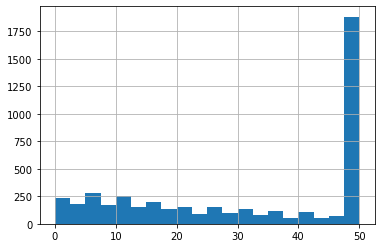

In [185]:
pd.Series([len(r) for r in reviews_content]).hist(bins=20)

In [208]:
place_id_mapping = {k: v for v, (k, _) in enumerate(reviews_m50)}
place_ids = [k for k, _ in reviews_m50]

reviews_content = [v for _, v in reviews_m50]

In [216]:
import spacy

nlp = spacy.load("en_core_web_sm")
lemmatizer = Lemmatizer(nlp)

# reviews[0][0], ' '.join(lemmatizer.lemmatize(reviews[0][0]))

In [187]:
def no_op_tokenize_func(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=no_op_tokenize_func,
    preprocessor=no_op_tokenize_func,
    token_pattern=None,
    # ngram_range=(1,2),
    max_features=10000
)

In [217]:
def gen_concat_doc(lemmatizer, texts):
    """Concatenate all docs (review texts) for the same place into one single doc."""
    yield from chain(*[lemmatizer.lemmatize(doc) for doc in texts])

In [218]:
docs_with_pos = [list(gen_concat_doc(lemmatizer, doc)) for doc in reviews_content]

In [220]:
def drop_pos(docs):
    return [[d[0] for d in doc] for doc in docs]

docs_without_pos = drop_pos(docs_with_pos)

In [221]:
print(len(docs_without_pos))
tfidf.fit(docs_without_pos)

4598


TfidfVectorizer(max_features=10000,
                preprocessor=<function no_op_tokenize_func at 0x138b9a280>,
                token_pattern=None,
                tokenizer=<function no_op_tokenize_func at 0x138b9a280>)

In [225]:
from collections import defaultdict

def identify_dominant_word_pos(docs):
    """Tally the part-of-speeach tags for each word,
    so that for words with multiple POS tags, we will keep the most dominant POS tag.
    """
    
    word_pos_tags = {}
    dominant_tag_for_word = {}
    
    for doc in docs:
        for word, pos in doc:
            if word not in word_pos_tags:
                word_pos_tags[word] = defaultdict(int)
                
            word_pos_tags[word][pos] += 1
            
    for word, tally in word_pos_tags.items():
        dominant_tag = sorted(tally.items(), key=lambda x: -x[1])[0][0]
        dominant_tag_for_word[word] = dominant_tag
        
    return dominant_tag_for_word

In [226]:
dominant_tag_for_word = identify_dominant_word_pos(docs_with_pos)

In [228]:
dominant_tag_for_word['nice']

'ADJ'

In [22]:
def get_high_idf_tokens(tfidf, top_k=50):
    high_idf_indices = np.argsort(tfidf.idf_)[::-1]
    features = tfidf.get_feature_names()
    
    tokens = []
    for i in range(top_k):
        idx = high_idf_indices[i]
        tokens.append((features[idx], tfidf.idf_[idx]))
        
    return tokens

In [47]:
get_high_idf_tokens(tfidf)[:10]

[('medicaid', 8.740881769595523),
 ('rachet', 8.740881769595523),
 ('radiation', 8.740881769595523),
 ('radiate', 8.740881769595523),
 ('rad', 8.740881769595523),
 ('racketball', 8.740881769595523),
 ('racist', 8.740881769595523),
 ('racism', 8.740881769595523),
 ('raccoo', 8.740881769595523),
 ('radish', 8.740881769595523)]

In [202]:
transformed_place_vecs = tfidf.transform(docs)

In [203]:
transformed_place_vecs.shape

(4598, 10000)

In [60]:
pid = place_id_mapping['ChIJX_PkfxsMzokRyg_Wdr6Nt2U']
pid

2394

In [204]:
cosine_sim = transformed_place_vecs @ transformed_place_vecs.T

In [53]:
np.argsort(cosine_sim[3591, :])[::-1][:10]

array([0])

In [61]:
np.argsort(np.asarray(cosine_sim[2394, :].todense()).squeeze())[::-1][:10]

array([2394, 2385, 1800, 2734, 4477,  490, 3780, 3902,  452, 1676])

In [115]:
import pandas as pd
df = pd.read_parquet("park_info_with_review_tag.parquet")
id_to_name_mapping = {pid: name for pid, name in zip(df['id'].values, df['name'].values)}

In [116]:
def get_most_similar_parks(row_id, k=10):
    sim_scores = np.asarray(cosine_sim[row_id, :].todense()).squeeze()
    similar_row_ids = np.argsort(sim_scores)[::-1]
    
    for rid, score in zip(similar_row_ids, sim_scores[similar_row_ids]):
        print(f"[{score:.3f}] {rid:5d} = {id_to_name_mapping[place_ids[rid]]}")

In [210]:
get_most_similar_parks(place_id_mapping['ChIJv7qvtP3NxokRxuok-WUh3O0'])

[1.000]  4218 = Timber Creek Dog Park
[0.808]  3622 = Blydenbugh Dog Park Area
[0.794]   560 = Freedom Barks
[0.775]  3261 = Rumbrook Park East Dog Park
[0.772]  2106 = Lloyd Park
[0.764]  2011 = Yorktown Community Dog Park
[0.763]   431 = MonDaug Bark Park
[0.760]  1949 = Swedes Run Dog Park
[0.759]  2369 = Falls Township Dog Park
[0.756]  3108 = Duke's Dog Run at Freedom Park


In [214]:
get_most_similar_parks(place_id_mapping['ChIJK2U1rU5YwokRjywqQmiBZaE'], k=20)

[1.000]  1479 = Pier 84 at Hudson River Park
[0.552]  3633 = Pier I
[0.526]  1664 = Pier 45 at Hudson River Park
[0.510]   755 = Fleischmann's Pier Park
[0.498]   919 = Pier 26 at Hudson River Park
[0.495]   803 = West Harlem Piers
[0.482]  1711 = Pier 51 at Hudson River Park
[0.478]   852 = Pier 46 at Hudson River Park
[0.445]  1206 = Pier 64 at Hudson River Park
[0.441]   553 = Maxwell Place Park
[0.430]  3599 = Christopher Street Pier
[0.429]  3718 = Senasqua Park
[0.428]   568 = Scenic Hudson Park
[0.427]  1653 = MacEachron Waterfront Park
[0.424]  3050 = Louis Engel Waterfront Park
[0.421]  1605 = Pier C Park
[0.420]  3848 = Hudson River Park
[0.417]  2194 = Pierson Park
[0.415]  1587 = Riverfront Green Park
[0.413]  2222 = North 5th Street Pier and Park


In [242]:
def print_top_tfidf_tokens_vec(scores, top_k=20, noun_verb_only=False):
    features = tfidf.get_feature_names()
    tf_idf_scores = np.asarray(scores.todense()).squeeze()
    sorted_indices = np.argsort(tf_idf_scores)[::-1]
    
    i = 0
    k = 0
    while k < top_k:
        idx = sorted_indices[i]
        i += 1
        
        if noun_verb_only:
            pos = dominant_tag_for_word[features[idx]]
            if pos != 'NOUN' and pos != 'VERB':
                continue
        k += 1
        print(f"[{tf_idf_scores[idx]:.3f}] {features[idx]}")
        
def print_top_tfidf_tokens(row_index, top_k=20, noun_verb_only=False):
    print_top_tfidf_tokens_vec(transformed_place_vecs[row_index, :],
                               top_k=top_k, noun_verb_only=noun_verb_only)
    

In [243]:
print_top_tfidf_tokens(place_id_mapping['ChIJmyIT0jUaxIkRhihmecUGMR0'], top_k=20, noun_verb_only=True)

[0.274] trail
[0.217] boat
[0.215] lake
[0.212] rental
[0.210] park
[0.204] kayak
[0.192] haycock
[0.152] place
[0.150] fishing
[0.136] water
[0.132] paddle
[0.122] love
[0.121] marina
[0.120] launch
[0.105] bike
[0.099] pool
[0.099] ride
[0.092] hike
[0.091] time
[0.086] swimming


In [232]:
global_doc = [w for doc in docs_without_pos for w in doc]

In [234]:
global_tf_idf = tfidf.transform([global_doc])

In [251]:
token_to_id = {w: i for i, w in enumerate(tfidf.get_feature_names())}
tfidf.idf_[token_to_id['park']]

1.1405450277714797

In [252]:
print_top_tfidf_tokens_vec(global_tf_idf, noun_verb_only=True, top_k=10)

[0.405] park
[0.259] place
[0.196] trail
[0.190] dog
[0.167] walk
[0.151] kid
[0.119] playground
[0.118] area
[0.115] love
[0.106] view


## Use non-negative matrix factorization (NMF) to find "topics" for parks

In this section, we can fit a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) and use it to convert (the reviews) of each park into a non-negative matrix $X$.

The matrix $X$ has shape $P \times V$, where $P$ is the number of parks, and $V$ is the size of our vocabulary.

We then use the [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) to decompose the word count matrix into $X \approx W * H$, by specifying $K$ topics/components.

Each component/topic will contain multiple words.

In [357]:
POS_WHITELIST = {'NOUN', 'VERB'}

docs_nouns_verbs_only = [
    [w for w, pos in doc if pos in POS_WHITELIST]
    for doc in docs_with_pos
]

In [359]:
tfidf_vec = TfidfVectorizer(
    analyzer='word',
    tokenizer=no_op_tokenize_func,
    preprocessor=no_op_tokenize_func,
    token_pattern=None,
    max_features=2000,
    # a word must at least occur in 3 parks
    min_df=5)

# this is the matrix X in the text above
park_word_mat = cnt_vec.fit_transform(docs_nouns_verbs_only)
park_word_mat.shape

(4598, 3000)

In [270]:
np.sum(park_word_mat.todense()[0, :])

116

In [360]:
from sklearn.decomposition import NMF

N_COMPONENTS = 100

# use a relatively large l1_ratio to encourage sparsity in the solutions
nmf_model = NMF(N_COMPONENTS, init='random', random_state=0, max_iter=2000,
                l1_ratio=0.75, alpha=3.0)
W = nmf_model.fit_transform(park_word_mat)

In [493]:
from matplotlib import pyplot as plt

def print_park_topics(place_id, top_k_topics=10):
    print(np.sort(W[place_id_mapping[place_id], :])[::-1][:top_k_topics])
    print(np.argsort(W[place_id_mapping[place_id], :])[::-1][:top_k_topics])
    plt.subplot(2, 1, 1)
    plt.plot(W[place_id_mapping[place_id], :])
    
    plt.subplot(2, 1, 2)
    sorted_contrib = np.sort(W[place_id_mapping[place_id], :])[::-1]
    norm_sorted_contrib = sorted_contrib / np.sum(sorted_contrib)
    cum_contrib = np.cumsum(norm_sorted_contrib)
    print("Cum. contribution @ component 5:", cum_contrib[4])
    plt.plot(cum_contrib)

[0.19923995 0.1561291  0.140622   0.13759429 0.11586954 0.09515013
 0.08953305 0.08081613 0.07590476 0.0740653 ]
[ 0 85 44 65 15 49  9 25 90 55]
Cum. contribution @ component 5: 0.4001493565862811


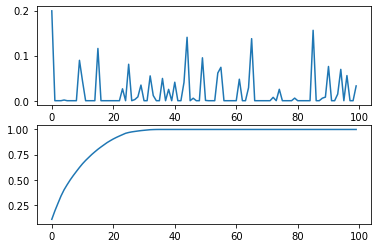

In [494]:
print_park_topics("ChIJ6TFIKYC3xokRmfC2e01b-Ik")

In [369]:
H = nmf_model.components_
H.shape

(100, 3000)

In [366]:
features = cnt_vec.get_feature_names()

def print_top_tokens_for_component(H, component_index, top_k=20):
    words = H[component_index, :]
    top_tokens = np.argsort(words)[::-1][:top_k]
    for t in top_tokens:
        print(f"[{words[t]:.4f}] {features[t]}")

In [517]:
print_top_tokens_for_component(H, 51, top_k=20)

[7.2780] site
[4.9582] camping
[3.9435] camp
[3.3933] campground
[2.3712] state
[1.9206] tent
[1.9092] campsite
[1.8970] stay
[1.4383] shower
[1.3816] trail
[1.2828] hiking
[1.2546] cabin
[1.2503] camper
[1.2208] lot
[1.1799] loop
[1.1723] ranger
[1.1327] hike
[1.0808] day
[1.0184] night
[0.9822] fishing


In [399]:
components_sim = H_norm @ H_norm.T

In [398]:
H_norm = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-4)

In [395]:
H_norm

array([[0.00082799, 0.        , 0.00016195, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00140432, 0.        , ..., 0.        , 0.        ,
        0.02941775],
       [0.        , 0.        , 0.        , ..., 0.00286966, 0.        ,
        0.00346445],
       ...,
       [0.        , 0.00025018, 0.        , ..., 0.00062851, 0.        ,
        0.00598998],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00667324,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

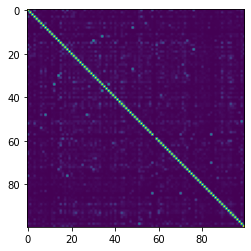

In [400]:
plt.imshow(components_sim)

In [542]:
# generic words for park/place
# and generic verbs for visiting a park
# should be excluded.
stop_words = {
    'park', 'go', 'visit', 'restroom', 'come', 'place', 'spot', 'time', 'take',
    '#', '%', 'translate', 'love', 'bring', 'find', 'year', 'york'
}

In [469]:
def get_top_words_from_topics(H, top_k=2):
    top_words = []
    
    for i in range(H.shape[0]):
        words = -H[i, :]
        top_tokens = np.argpartition(words, top_k)[:top_k]
    
        words = [features[t] for t in top_tokens]
        
        top_words.append([w for w in words if w not in stop_words])
        
    return top_words

In [543]:
def get_top_words_from_topics_by_weight(H, min_weight=2.0):
    top_words = []
    
    for i in range(H.shape[0]):
        word_weights = H[i, :]
        top_tokens = np.argsort(word_weights)[::-1]
    
        words = [features[t] for t in top_tokens
                 if word_weights[t] >= min_weight]
        
        top_words.append([w for w in words if w not in stop_words])
        
    return top_words

In [544]:
top_words = get_top_words_from_topics_by_weight(H)
top_words

[[],
 ['house', 'fairy'],
 ['summer', 'concert'],
 ['pavilion'],
 ['maintain', 'keep', 'plenty'],
 ['pool'],
 ['manhattan', 'brooklyn', 'skyline', 'pier', 'city', 'ferry'],
 ['dog', 'owner'],
 ['view'],
 ['look'],
 [],
 ['family', 'friend'],
 ['course', 'green', 'tee'],
 ['bathroom'],
 ['trail', 'walk'],
 [],
 ['playground', 'kid', 'play', 'age'],
 ['sculpture', 'ground', 'art'],
 ['basketball', 'court', 'playground', 'handball'],
 ['bird', 'wildlife', 'watch', 'see'],
 ['swing', 'sprinkler', 'slide', 'equipment', 'age', 'kid'],
 ['event', 'music', 'food', 'center', 'festival', 'concert'],
 ['store', 'price', 'item'],
 ['enjoy'],
 ['skate', 'ice', 'rink'],
 ['zoo', 'animal'],
 ['water', 'fountain'],
 ['river', 'delaware'],
 ['statue', 'liberty'],
 ['relax', 'sit'],
 ['hike', 'trail', 'hiking'],
 ['nature', 'center'],
 ['fall', 'waterfall'],
 ['food', 'service', 'restaurant', 'drink'],
 ['disc', 'course', 'golf', 'hole'],
 ['island', 'ride'],
 [],
 ['golf'],
 ['memorial', 'lose', 'life'

In [545]:
import orjson

def dump_park_topics(W, place_id_mapping, output_file=None,
                     min_component_weight=0.2, min_word_weight=2.0):
    park_topics = {}
    
    for k, pid in place_id_mapping.items():
        comp_weights = W[pid, :]
        top_components = np.argsort(comp_weights)[::-1]
        
        topics = []
        for comp_id in top_components:
            weight = comp_weights[comp_id]
            if weight >= min_component_weight:
                if top_words[comp_id]:
                    topics.append({
                        'topic_id': int(comp_id),
                        'weight': float(weight),
                        'topics': top_words[comp_id]
                    })
            else:
                break
                
        park_topics[k] = topics
        
    if output_file:
        with open(output_file, 'wb+') as f:
            f.write(orjson.dumps(park_topics))
            
    return park_topics
        

In [546]:
park_topics_by_id = dump_park_topics(W, place_id_mapping, 'park_topics_by_id.json')